# **Importing Libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [5]:
#Import tensorflow and keras modules
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras_flops import get_flops
import tensorflow as tf

#Import other modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talos
import math
import pickle
import os
%matplotlib inline

In [6]:
#Save Model Function
def save_m(file, model):
    if not os.path.exists(file):
        os.makedirs(file)

    model.save_weights(file+'/model.h5')
    model_json = model.to_json()
    with open(file + "/model.json", "w") as json_file:
        json_file.write(model_json)

#Save History Function
def save_h(file, history):
    if not os.path.exists(file):
        os.makedirs(file)

    with open(file + '/' + 'model.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)

#Load Model Function
def load_m(file):
	if not os.path.exists(file) and file != 'EnsembleModel':
		print("\n[ERROR] Model path '" + file +  "' does not exist.")
		exit()

	with open(file + "/model.json", "r") as json_file:
		model = json_file.read()
		model = model_from_json(model)
		model.load_weights(file+'/model.h5')
		return model

#Load History Function
def load_h(file):
    with open(file + '/' + 'model.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

#Get data from generator function
def get_data(generator, nb_samples):  
    from tqdm.notebook import tqdm
    x = []
    y = []

    for i in tqdm(range(math.ceil(nb_samples/BATCH_SIZE))):
        x.extend(generator[i][0])
        y.extend(generator[i][1])

    x = np.array(x)
    y = np.array(y)
    return x, y

#Create generator from data function
def get_generator(x, y, preprocess_input, shuffle=True):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen = datagen.flow(x, y, batch_size=BATCH_SIZE, shuffle=shuffle)
    return datagen

# **Loading Data**

In [7]:
#Define Constants
IMAGE_SIZE = (256, 256)
MODEL_INPUT = Input(shape=(256, 256, 3))
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

#Data paths
TRAIN_DATA_PATH = 'ds/train/'
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model path
DIST_STUDENT_MODEL_PATH = 'models/Distilled_Student_Models/'
NORMAL_STUDENT_MODEL_PATH = 'models/Student_Models/'
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

TEACHER_NAME = 'EfficientNetB7'
STUDENT_NAME = 'KD-DenseNet121'

In [ ]:
#Create Generator from datapath
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(TRAIN_DATA_PATH, 
                                                    target_size=IMAGE_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator = datagen.flow_from_directory(VAL_DATA_PATH, 
                                                        target_size=IMAGE_SIZE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical',
                                                        shuffle=False)

test_generator = datagen.flow_from_directory(TEST_DATA_PATH, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  shuffle=False)

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)
num_classes= len(train_generator.class_indices)

print('NUMBER OF TRAIN SAMPLES:', nb_train_samples)
print('NUMBER OF VALIDATION SAMPLES:',nb_validation_samples)
print('NUMBER OF TEST SAMPLES:',nb_test_samples)
print('TOTAL CLASSES:', num_classes)

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
NUMBER OF TRAIN SAMPLES: 1990
NUMBER OF VALIDATION SAMPLES: 1194
NUMBER OF TEST SAMPLES: 796
TOTAL CLASSES: 199


# **Knowledge Distillation**

**KD Class**

In [ ]:
class KDistiller(Model):
    def __init__(self, student, teacher):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha,
        temperature,
    ):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_preds = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_preds)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics 
        self.compiled_metrics.update_state(y, student_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'combined_loss':loss}
        )

        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_preds = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_preds)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model**

In [ ]:
# Load the teacher
def get_teacher(directory):
    model = load_m(directory)
    return model

print("TEACHER MODEL\n\n\n")
get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME).summary()

TEACHER MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 199)               509639    
Total params: 64,607,326
Trainable params: 64,296,599
Non-trainable params: 310,727
_________________________________________________________________


**Student Model**

In [ ]:
#Create the student
def get_student():
    transfer = densenet.DenseNet121(include_top = False, weights = 'imagenet', input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    gap2D = GlobalAveragePooling2D()(transfer.layers[-1].output)
    drop = Dropout(0.5)(gap2D)
    classifier = Dense(199)(drop)
    
    model = Model(inputs = transfer.inputs, outputs = classifier)
    model.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

    return model

print("STUDENT MODEL\n\n\n")
get_student().summary()

STUDENT MODEL



29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________

**Training Student With KD**

In [ ]:
#Get training data in x, y format
print("Loading Training Data")
x_train, y_train = get_data(train_generator, nb_train_samples)

print("Loading Validation Data")
x_val, y_val = get_data(validation_generator, nb_validation_samples)

print("Loading Testing Data")
x_test, y_test = get_data(test_generator, nb_test_samples)

Loading Training Data


  0%|          | 0/498 [00:00<?, ?it/s]

Loading Validation Data


  0%|          | 0/299 [00:00<?, ?it/s]

Loading Testing Data


  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
#Get training data in x, y format
print("Loading Training Data")
x_train, y_train = get_data(train_generator, nb_train_samples)

print("Loading Validation Data")
x_val, y_val = get_data(validation_generator, nb_validation_samples)

print("Loading Testing Data")
x_test, y_test = get_data(test_generator, nb_test_samples)

Loading Training Data



Loading Validation Data



Loading Testing Data


In [ ]:
# Distill teacher to student
p = {
    'temperature':[2, 3, 5, 10],
    'alpha':[0.1, 0.3, 0.5] 
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    #Get teacher and student model                
    teacher = get_teacher(TEACHER_MODEL_PATH  + TEACHER_NAME)
    student = get_student()

    #Create Knowledge distiller
    distiller = KDistiller(student=student, teacher=teacher)

    #Compile Knowledge distiller
    distiller.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE),
        metrics=[CategoricalAccuracy()],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    #Get train and test generator
    train_generator = get_generator(x_train, y_train, densenet.preprocess_input)
    validation_generator = get_generator(x_val, y_val, densenet.preprocess_input)

    #Training
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples// BATCH_SIZE,
                                        validation_steps = nb_validation_samples// BATCH_SIZE,
                                        epochs=EPOCHS
                                      )

    return distiller_history, distiller.student

scan_object = talos.Scan(x_train, y_train, experiment_name=STUDENT_NAME+'exp', x_val=x_val, y_val=y_val, model=distiller_model, params=p)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Epoch 1/30
497/497 [==============================] - 119s 211ms/step - categorical_accuracy: 0.0060 - student_loss: 5.5847 - distillation_loss: 0.0608 - combined_loss: 0.6132 - val_categorical_accuracy: 0.0059 - val_student_loss: 5.4465
Epoch 2/30
497/497 [==============================] - 100s 202ms/step - categorical_accuracy: 0.0055 - student_loss: 5.4171 - distillation_loss: 0.0388 - combined_loss: 0.5766 - val_categorical_accuracy: 0.0109 - val_student_loss: 5.0340
Epoch 3/30
497/497 [==============================] - 105s 211ms/step - categorical_accuracy: 0.0101 - student_loss: 5.2749 - distillation_loss: 0.0425 - combined_loss: 0.5657 - val_categorical_accuracy: 0.0109 - val_student_loss: 4.9699
Epoch 4/30
497/497 [==============================] - 100s 201ms/step - categorical_accuracy: 0.0363 - student_loss: 4.9731 - distillation_loss: 0.0521 - combined_loss: 0.5442 - val_categorical_accuracy: 0.1812 - val_student_loss: 3.5550
Epoch 5/30
497/497 [============================

  8%|██████▌                                                                        | 1/12 [50:49<9:19:05, 3049.55s/it]

Epoch 1/30
497/497 [==============================] - 113s 206ms/step - categorical_accuracy: 0.0060 - student_loss: 5.6089 - distillation_loss: 0.0384 - combined_loss: 0.5955 - val_categorical_accuracy: 0.0109 - val_student_loss: 5.5048
Epoch 2/30
497/497 [==============================] - 102s 205ms/step - categorical_accuracy: 0.0196 - student_loss: 5.2126 - distillation_loss: 0.0311 - combined_loss: 0.5492 - val_categorical_accuracy: 0.0696 - val_student_loss: 4.9377
Epoch 3/30
497/497 [==============================] - 99s 198ms/step - categorical_accuracy: 0.0720 - student_loss: 4.6997 - distillation_loss: 0.0431 - combined_loss: 0.5087 - val_categorical_accuracy: 0.2374 - val_student_loss: 4.3228
Epoch 4/30
497/497 [==============================] - 99s 200ms/step - categorical_accuracy: 0.2039 - student_loss: 3.9291 - distillation_loss: 0.0609 - combined_loss: 0.4477 - val_categorical_accuracy: 0.5050 - val_student_loss: 3.5038
Epoch 5/30
497/497 [==============================

 17%|████████████▊                                                                | 2/12 [1:40:17<8:20:17, 3001.75s/it]

Epoch 1/30
497/497 [==============================] - 108s 197ms/step - categorical_accuracy: 0.0076 - student_loss: 5.5553 - distillation_loss: 0.0220 - combined_loss: 0.5754 - val_categorical_accuracy: 0.1082 - val_student_loss: 4.8151
Epoch 2/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.0705 - student_loss: 4.6604 - distillation_loss: 0.0234 - combined_loss: 0.4871 - val_categorical_accuracy: 0.2550 - val_student_loss: 3.6659
Epoch 3/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.2231 - student_loss: 3.7520 - distillation_loss: 0.0289 - combined_loss: 0.4012 - val_categorical_accuracy: 0.5042 - val_student_loss: 2.9235
Epoch 4/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.4592 - student_loss: 2.8770 - distillation_loss: 0.0331 - combined_loss: 0.3175 - val_categorical_accuracy: 0.6586 - val_student_loss: 2.2559
Epoch 5/30
497/497 [==============================]

 25%|███████████████████▎                                                         | 3/12 [2:29:11<7:25:37, 2970.85s/it]

Epoch 1/30
497/497 [==============================] - 109s 198ms/step - categorical_accuracy: 0.0171 - student_loss: 5.5607 - distillation_loss: 0.0078 - combined_loss: 0.5630 - val_categorical_accuracy: 0.0982 - val_student_loss: 4.3609
Epoch 2/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.1078 - student_loss: 4.3834 - distillation_loss: 0.0074 - combined_loss: 0.4450 - val_categorical_accuracy: 0.3238 - val_student_loss: 3.0961
Epoch 3/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.2674 - student_loss: 3.4872 - distillation_loss: 0.0088 - combined_loss: 0.3566 - val_categorical_accuracy: 0.5973 - val_student_loss: 1.5756
Epoch 4/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.4869 - student_loss: 2.6678 - distillation_loss: 0.0101 - combined_loss: 0.2759 - val_categorical_accuracy: 0.7131 - val_student_loss: 2.5682
Epoch 5/30
497/497 [==============================]

 33%|█████████████████████████▋                                                   | 4/12 [3:18:12<6:34:29, 2958.71s/it]

Epoch 1/30
497/497 [==============================] - 111s 202ms/step - categorical_accuracy: 0.0121 - student_loss: 5.5277 - distillation_loss: 0.1130 - combined_loss: 1.7374 - val_categorical_accuracy: 0.0512 - val_student_loss: 4.9609
Epoch 2/30
497/497 [==============================] - 99s 200ms/step - categorical_accuracy: 0.0433 - student_loss: 4.9094 - distillation_loss: 0.1102 - combined_loss: 1.5499 - val_categorical_accuracy: 0.2592 - val_student_loss: 4.1411
Epoch 3/30
497/497 [==============================] - 101s 204ms/step - categorical_accuracy: 0.1586 - student_loss: 4.0627 - distillation_loss: 0.1632 - combined_loss: 1.3331 - val_categorical_accuracy: 0.4874 - val_student_loss: 2.5864
Epoch 4/30
497/497 [==============================] - 99s 200ms/step - categorical_accuracy: 0.3499 - student_loss: 3.2406 - distillation_loss: 0.1933 - combined_loss: 1.1075 - val_categorical_accuracy: 0.6770 - val_student_loss: 2.1496
Epoch 5/30
497/497 [==============================

 42%|████████████████████████████████                                             | 5/12 [4:07:33<5:45:16, 2959.54s/it]

Epoch 1/30
497/497 [==============================] - 108s 196ms/step - categorical_accuracy: 0.0131 - student_loss: 5.5987 - distillation_loss: 0.0738 - combined_loss: 1.7312 - val_categorical_accuracy: 0.0965 - val_student_loss: 4.6894
Epoch 2/30
497/497 [==============================] - 98s 198ms/step - categorical_accuracy: 0.0952 - student_loss: 4.4700 - distillation_loss: 0.0747 - combined_loss: 1.3933 - val_categorical_accuracy: 0.3372 - val_student_loss: 2.0383
Epoch 3/30
497/497 [==============================] - 101s 203ms/step - categorical_accuracy: 0.2795 - student_loss: 3.5156 - distillation_loss: 0.0868 - combined_loss: 1.1155 - val_categorical_accuracy: 0.6225 - val_student_loss: 1.9233
Epoch 4/30
497/497 [==============================] - 98s 197ms/step - categorical_accuracy: 0.4960 - student_loss: 2.6922 - distillation_loss: 0.1011 - combined_loss: 0.8785 - val_categorical_accuracy: 0.6804 - val_student_loss: 1.6665
Epoch 5/30
497/497 [==============================

 50%|██████████████████████████████████████▌                                      | 6/12 [4:56:36<4:55:24, 2954.02s/it]

Epoch 1/30
497/497 [==============================] - 109s 197ms/step - categorical_accuracy: 0.0141 - student_loss: 5.6450 - distillation_loss: 0.0301 - combined_loss: 1.7145 - val_categorical_accuracy: 0.0864 - val_student_loss: 4.9269
Epoch 2/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.0831 - student_loss: 4.5547 - distillation_loss: 0.0286 - combined_loss: 1.3864 - val_categorical_accuracy: 0.3054 - val_student_loss: 3.7724
Epoch 3/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.2558 - student_loss: 3.6184 - distillation_loss: 0.0336 - combined_loss: 1.1091 - val_categorical_accuracy: 0.5394 - val_student_loss: 2.2644
Epoch 4/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.4743 - student_loss: 2.7763 - distillation_loss: 0.0387 - combined_loss: 0.8600 - val_categorical_accuracy: 0.6586 - val_student_loss: 2.0918
Epoch 5/30
497/497 [==============================]

 58%|████████████████████████████████████████████▉                                | 7/12 [5:45:45<4:06:02, 2952.41s/it]

Epoch 1/30
497/497 [==============================] - 110s 200ms/step - categorical_accuracy: 0.0151 - student_loss: 5.6208 - distillation_loss: 0.0084 - combined_loss: 1.6921 - val_categorical_accuracy: 0.1133 - val_student_loss: 4.2339
Epoch 2/30
497/497 [==============================] - 99s 198ms/step - categorical_accuracy: 0.1193 - student_loss: 4.3448 - distillation_loss: 0.0079 - combined_loss: 1.3090 - val_categorical_accuracy: 0.4002 - val_student_loss: 3.1314
Epoch 3/30
497/497 [==============================] - 99s 199ms/step - categorical_accuracy: 0.3041 - student_loss: 3.4147 - distillation_loss: 0.0092 - combined_loss: 1.0309 - val_categorical_accuracy: 0.5914 - val_student_loss: 2.6621
Epoch 4/30
497/497 [==============================] - 98s 198ms/step - categorical_accuracy: 0.4955 - student_loss: 2.6012 - distillation_loss: 0.0107 - combined_loss: 0.7879 - val_categorical_accuracy: 0.7215 - val_student_loss: 1.2763
Epoch 5/30
497/497 [==============================]

 67%|███████████████████████████████████████████████████▎                         | 8/12 [6:35:01<3:16:54, 2953.65s/it]

Epoch 1/30
497/497 [==============================] - 109s 198ms/step - categorical_accuracy: 0.0136 - student_loss: 5.5723 - distillation_loss: 0.1477 - combined_loss: 2.8600 - val_categorical_accuracy: 0.0906 - val_student_loss: 4.8291
Epoch 2/30
497/497 [==============================] - 98s 197ms/step - categorical_accuracy: 0.0665 - student_loss: 4.7060 - distillation_loss: 0.1563 - combined_loss: 2.4312 - val_categorical_accuracy: 0.2777 - val_student_loss: 2.2996
Epoch 3/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.2185 - student_loss: 3.7748 - distillation_loss: 0.1952 - combined_loss: 1.9850 - val_categorical_accuracy: 0.5025 - val_student_loss: 2.9663
Epoch 4/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.4451 - student_loss: 2.8484 - distillation_loss: 0.2260 - combined_loss: 1.5372 - val_categorical_accuracy: 0.6493 - val_student_loss: 2.1738
Epoch 5/30
497/497 [==============================]

 75%|█████████████████████████████████████████████████████████▊                   | 9/12 [7:24:05<2:27:31, 2950.41s/it]

Epoch 1/30
497/497 [==============================] - 109s 197ms/step - categorical_accuracy: 0.0030 - student_loss: 5.7478 - distillation_loss: 0.0690 - combined_loss: 2.9084 - val_categorical_accuracy: 0.0327 - val_student_loss: 4.9993
Epoch 2/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.0423 - student_loss: 4.9668 - distillation_loss: 0.0686 - combined_loss: 2.5177 - val_categorical_accuracy: 0.1812 - val_student_loss: 3.9970
Epoch 3/30
497/497 [==============================] - 97s 195ms/step - categorical_accuracy: 0.1596 - student_loss: 4.0522 - distillation_loss: 0.0918 - combined_loss: 2.0720 - val_categorical_accuracy: 0.4564 - val_student_loss: 1.9543
Epoch 4/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.3771 - student_loss: 3.1013 - distillation_loss: 0.1076 - combined_loss: 1.6045 - val_categorical_accuracy: 0.6854 - val_student_loss: 2.0669
Epoch 5/30
497/497 [==============================]

 83%|███████████████████████████████████████████████████████████████▎            | 10/12 [8:13:00<1:38:11, 2945.73s/it]

Epoch 1/30
497/497 [==============================] - 109s 198ms/step - categorical_accuracy: 0.0091 - student_loss: 5.7052 - distillation_loss: 0.0274 - combined_loss: 2.8663 - val_categorical_accuracy: 0.0797 - val_student_loss: 4.3661
Epoch 2/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.0609 - student_loss: 4.7398 - distillation_loss: 0.0269 - combined_loss: 2.3834 - val_categorical_accuracy: 0.2886 - val_student_loss: 3.8439
Epoch 3/30
497/497 [==============================] - 98s 197ms/step - categorical_accuracy: 0.2175 - student_loss: 3.7613 - distillation_loss: 0.0340 - combined_loss: 1.8976 - val_categorical_accuracy: 0.5369 - val_student_loss: 1.9653
Epoch 4/30
497/497 [==============================] - 98s 196ms/step - categorical_accuracy: 0.4431 - student_loss: 2.8420 - distillation_loss: 0.0404 - combined_loss: 1.4412 - val_categorical_accuracy: 0.6569 - val_student_loss: 3.2961
Epoch 5/30
497/497 [==============================]

 92%|███████████████████████████████████████████████████████████████████████▌      | 11/12 [9:02:12<49:07, 2947.78s/it]

Epoch 1/30
497/497 [==============================] - 109s 199ms/step - categorical_accuracy: 0.0136 - student_loss: 5.6042 - distillation_loss: 0.0081 - combined_loss: 2.8062 - val_categorical_accuracy: 0.0847 - val_student_loss: 4.7586
Epoch 2/30
497/497 [==============================] - 97s 196ms/step - categorical_accuracy: 0.0916 - student_loss: 4.4607 - distillation_loss: 0.0077 - combined_loss: 2.2342 - val_categorical_accuracy: 0.3591 - val_student_loss: 3.9454
Epoch 3/30
497/497 [==============================] - 98s 196ms/step - categorical_accuracy: 0.2810 - student_loss: 3.5168 - distillation_loss: 0.0091 - combined_loss: 1.7629 - val_categorical_accuracy: 0.5587 - val_student_loss: 3.6001
Epoch 4/30
497/497 [==============================] - 98s 196ms/step - categorical_accuracy: 0.4773 - student_loss: 2.7193 - distillation_loss: 0.0107 - combined_loss: 1.3650 - val_categorical_accuracy: 0.6787 - val_student_loss: 2.5409
Epoch 5/30
497/497 [==============================]

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [9:51:12<00:00, 2956.01s/it]


In [ ]:
r = talos.Reporting(STUDENT_NAME + 'exp/results.csv')
model_index = r.data.loc[r.data['val_categorical_accuracy'] == np.max(r.data['val_categorical_accuracy'])].index[0]
val_acc = np.max(r.data['val_categorical_accuracy'])

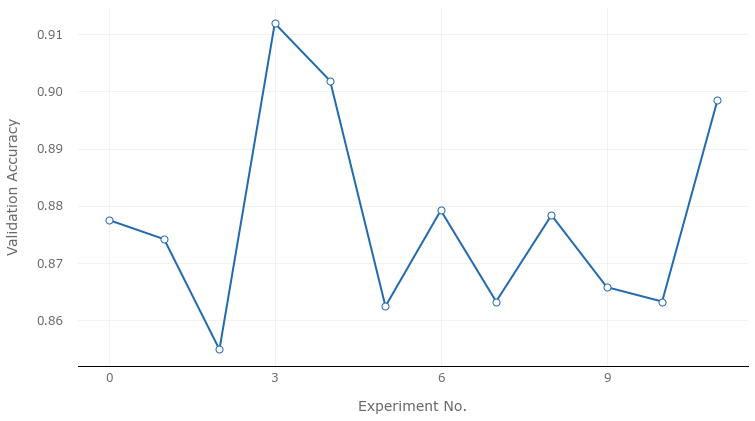

In [ ]:
#See the line plot -> model_index vs validation accuracy 
r.plot_line('val_categorical_accuracy')
plt.xlabel('Experiment No.')
plt.ylabel('Validation Accuracy')
plt.xticks(range(12))
plt.annotate( 'max validation accuray', (model_index, val_acc))
plt.show()

In [ ]:
#See the result of best student
r.data.iloc[[model_index]]

,round_epochs,categorical_accuracy,student_loss,distillation_loss,combined_loss,val_categorical_accuracy,val_student_loss,alpha,temperature,Unnamed: 9
3,30,0.997986,0.024375,0.018078,0.018708,0.911913,0.169322,0.1,10,NaN


In [ ]:
#Create best Student
best_student = model_from_json(scan_object.saved_models[model_index])
weights = scan_object.saved_weights[model_index]
best_student.set_weights(weights)

best_student.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

#Load teacher
temp_teacher = get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME)
temp_teacher.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

print("Evaluating Student on test dataset\n")
test_generator = get_generator(x_test, y_test, densenet.preprocess_input, shuffle=False)
s_acc = best_student.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

print("\nEvaluating Teacher on test dataset\n")
test_generator = get_generator(x_test, y_test, efficientnet.preprocess_input, shuffle=False)
t_acc = temp_teacher.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

Evaluating Student on test dataset

199/199 [==============================] - 46s 29ms/step - loss: 0.4397 - categorical_accuracy: 0.8740

Evaluating Teacher on test dataset

199/199 [==============================] - 58s 80ms/step - loss: 0.2800 - categorical_accuracy: 0.9386


**Saving Model**

In [ ]:
print("MODEL AND HISTORY SAVED")
#save models
save_m(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, best_student)

#save history
distiller_history = scan_object.round_history[model_index]
save_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, distiller_history)

**Final Results**

In [ ]:
student_acc = "{0:.3f} ".format(s_acc[1]*100)
student_size = "{0:.2f} M".format(best_student.count_params()/10**6)
student_flops = "{0:.2f} G".format(get_flops(Model(best_student.input, best_student.output), batch_size=1)/ 10 ** 9)

teacher_acc = "{0:.3f} ".format(t_acc[1]*100)
teacher_size = "{0:.2f} M".format(temp_teacher.count_params()/10**6)
teacher_flops = "{0:.2f} G".format(get_flops(Model(temp_teacher.input, temp_teacher.output), batch_size=1)/ 10 ** 9)

results = {STUDENT_NAME:{'Test Accuracy(%)':student_acc,
                         'Parameters':student_size,
                         'FLOPs':student_flops},
           TEACHER_NAME:{'Test Accuracy(%)':teacher_acc,
                         'Parameters':teacher_size,
                         'FLOPs':teacher_flops}}

results = pd.DataFrame(results)
results

,KD-DenseNet121,EfficientNetB7
Test Accuracy(%),88.147,92.932
Parameters,7.24 M,64.61 M
FLOPs,7.45 G,13.69 G


# **Training Visualization**

In [8]:
#VISUAL CUSTOMIZER
distiller_history = load_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME)

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10
fontsize = 7

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


**Accuracy Curve**

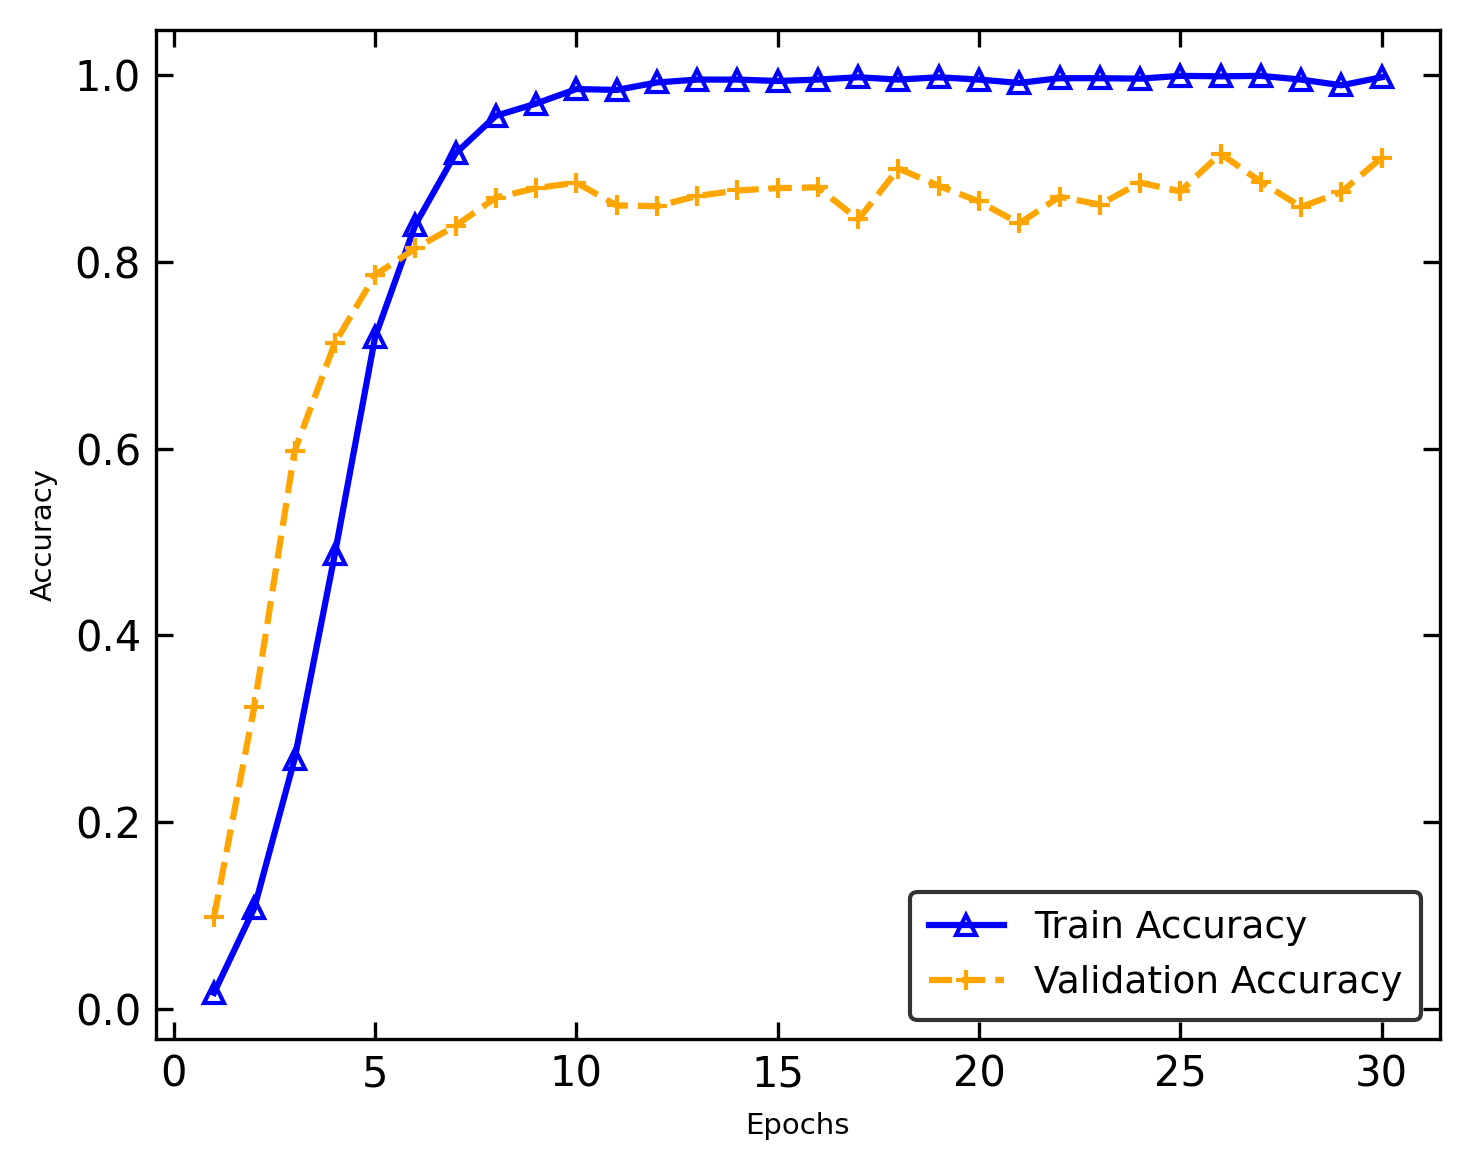

In [9]:
#PRINTS THE ACCURACY GROWTH
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in") 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), distiller_history["categorical_accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), distiller_history["val_categorical_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Accuracy", fontsize=fontsize, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()

**Loss Curve**

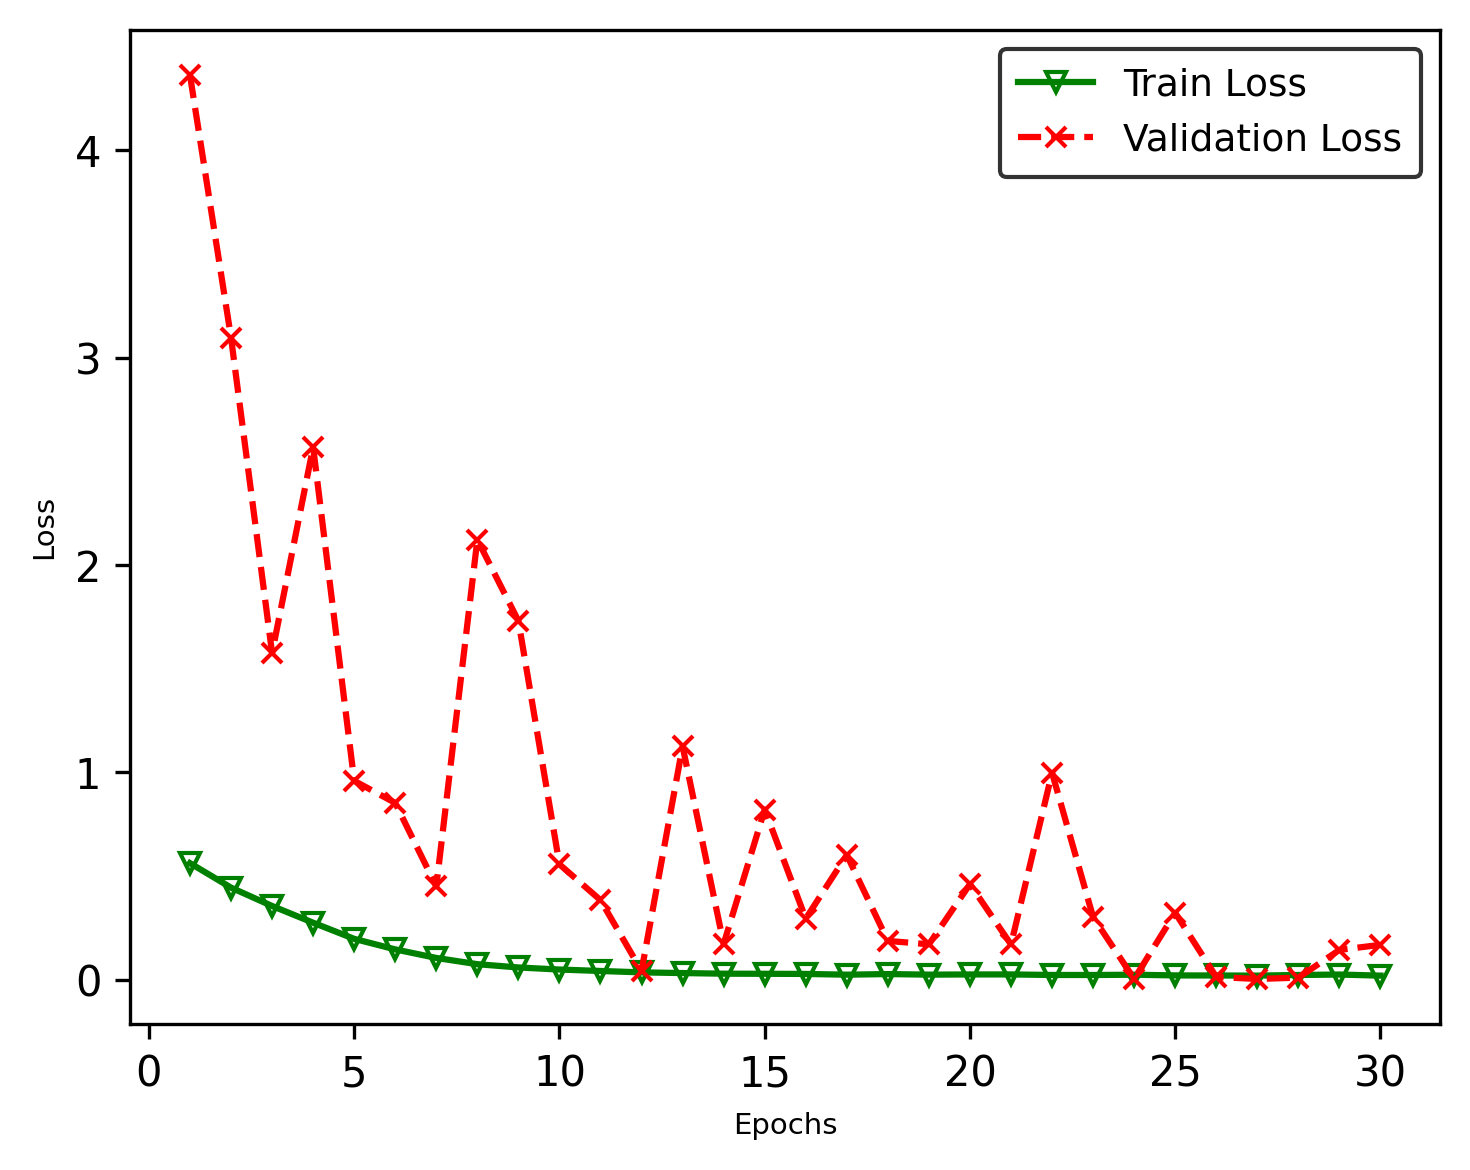

In [10]:
#PRINTS THE DECREASE OF LOSS
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.arange(1, N+1), distiller_history["combined_loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), distiller_history["val_student_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v, label="Validation Loss")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Loss", fontsize=fontsize, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()